# Cost efficient prompting for **RAG**-based tasks: Applying compression to retrieved context for token count reduction  

Authors:  
 - [Lior Gazit](https://www.linkedin.com/in/liorgazit).  
 - [Meysam Ghaffari](https://www.linkedin.com/in/meysam-ghaffari-ph-d-a2553088/).  

This notebook is taught and reviewed in our book:  
**[Mastering NLP from Foundations to LLMs](https://www.amazon.com/dp/1804619183)**  
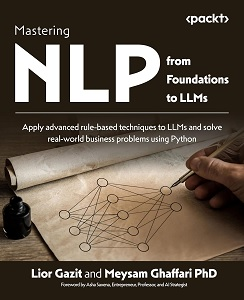

This Colab notebook is referenced in our book's Github repo:   
https://github.com/PacktPublishing/Mastering-NLP-from-Foundations-to-LLMs   
<a target="_blank" href="https://colab.research.google.com/github/PacktPublishing/Mastering-NLP-from-Foundations-to-LLMs/blob/seasonal_updates_2025/Chapter9_notebooks/Ch9_RAGLlamaIndex_Prompt_Compression.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

**The motivation for this notebook:**  
We set up this notebook so to serve as a study for the impact of using content compression for the RAG's retrieved context text.  
Typically, when applying the RAG scheme, the vast majority of the prompt's tokens are due to the context portion, meaning, the content that the RAG retrieved from the database to serve as the context for the LLM to refer to when performing the requested task.  
We examine the use of [**LongLLMLingua**](https://arxiv.org/abs/2310.06839), which aims at identifying low information density in long contextand apply prompt compression. By doing so, it reduces the number of sent tokens while attempting to maintain all the relevant pieces of information for answering the user's prompt.  
Not that the compression process is done with regards to the user's prompt.  
Moreover, the compression process is done on a free local LLM, Llama2, thus not increasing the API cost.  

**The description of the experiments:**  
Each experiment represents a user setting a RAG task for asking a question about a particular Arxiv publication.  
In each experiment, a single random Arxiv publication, which is categorized as an AI publication, is chosen. The user asks whether the publication's topic is around Reinforcement Learning, thus making the prompt be a request for a binary classification based on the publication's content. The LLM that we chose for performing this task is OpenAI's GPT.  
Now, since each publication is very long when compared to the maximal allowed prompt length, a RAG is applied. Each publication is chunked and filed in a vector database.
In each experiment, two approaches are employed:  
1. Context for the prompt is being retrieved, gets attached to the user's question, and sent to OpenAI's GPT for classification,  
1. Context for the prompt is being retrieved, **gets compressed by LongLLMLingua**, gets attached to the user's question, and sent to OpenAI's GPT for classification.  
The following metrics are measured for each of these two approaches:  
* Number of tokens sent to OpenAI's GPT  
* Processing time  
* Agreement/Disagreement in classification between the two  

**Outcome:**  
The notebook sums the study by presenting the trade offs for utilizing LongLLMLingua.  

See notebooke **Ch9_Completing_a_Complex_Analysis_with_a_Team_of_LLM_Agents.ipynb** as we employ a team of agents to finalize the results from this analysis.  

**Requirements:**  
* When running in Colab, use this runtime notebook setting: `Python 3, T4 GPU`  
* This code picks OpenAI's API as a choice of LLM, so a paid **API key** is necessary.   

>*```Disclaimer: The content and ideas presented in this notebook are solely those of the authors and do not represent the views or intellectual property of the authors' employers.```*

Install:

In [ ]:
# REMARK:
# If the below code error's out due to a Python package discrepency, it may be because new versions are causing it.
# In which case, set "default_installations" to False to revert to the original image:
default_installations = True
if default_installations:
  !pip -q install llmlingua llama-index==0.10.7 accelerate datasets llama-index-postprocessor-longllmlingua
else:
  import requests
  text_file_path = "requirements__Ch9_RAGLlamaIndex_Prompt_Compression.txt"
  url = "https://raw.githubusercontent.com/PacktPublishing/Mastering-NLP-from-Foundations-to-LLMs/main/Chapter9_notebooks/" + text_file_path
  res = requests.get(url)
  with open(text_file_path, "w") as f:
    f.write(res.text)

  !pip install -r requirements__Ch9_RAGLlamaIndex_Prompt_Compression.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 76.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 86.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 93.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.7/226.7 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 68.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.0/284.0 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

Import:

In [ ]:
import torch
import gc
import openai
from datasets import load_dataset
import pandas as pd
from llama_index.core import Document
from llama_index.core import VectorStoreIndex
from llama_index.llms.openai import OpenAI
from llama_index.core.indices.query.schema import QueryBundle
from llama_index.core.response_synthesizers import CompactAndRefine
from llama_index.postprocessor.longllmlingua import LongLLMLinguaPostprocessor
import random
import time
import pickle
import os

### Code Settings

In [ ]:
# This sets the prompted model type for the non-compressing RAG (the prompted
# model for the compressing RAG is set by default to "gpt-3.5-turbo", while
# the compressing model is set by default to "NousResearch/Llama-2-7b-hf")
gpt_type = "gpt-3.5-turbo"

# Number of experiments to run. Each experiment represents a user setting a RAG task for asking a question about a particular Arxiv publication:
num_of_iterations = 60

# As the Arxiv publication for each experiment is chosen at random, we set a fixed seed so to allow reproducibility of the original results:
set_seed = 0

# Number of similar chunks to retrieve by the RAG for each experiment:
similarity_top_k = 5

# A targen amount of tokens to aim to reduce to when compressing the retrieved context:
target_token = 2**9

In [ ]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

Define OpenAI's API key:  
**You must provide a key and paste it as a string!**  

In [ ]:
openai.api_key = "..."

## Gather the Data
The data is taken from here:  
https://huggingface.co/datasets/ccdv/arxiv-classification

It contains content of full [Arxiv](https://arxiv.org/) publications.  
We will focus on the AI category.  

In [ ]:
dataset = load_dataset("ccdv/arxiv-classification")
dataset_train = dataset["train"]
dataset_train_df = pd.DataFrame(dataset_train)

# Justin keeping the AI publications (categorized as #2):
dataset_train_df_ai = dataset_train_df[dataset_train_df["label"] == 2].reset_index(drop=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1454: FutureWarning: The repository for ccdv/arxiv-classification contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/ccdv/arxiv-classification
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `d

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Observe the full content of one of the publications:  

In [ ]:
dataset_train_df_ai.head(1).style.set_properties(**{'text-align': 'left'})

Define a list of llama_index documents types:  

In [ ]:
articles = [Document(text=content) for content in dataset_train_df_ai["text"]]

In [ ]:
print("'articles' is a list, where each elemnet is of type:", type(articles[0]))

'articles' is a list, where each elemnet is of type: <class 'llama_index.core.schema.Document'>


## LLMs Configurations
Configure the LLM via OpenAI's API, and configure the LongLLMLinguaPostprocessor.  

In [ ]:
llm = OpenAI(model=gpt_type)
query = "Does this publication involve Reinforcement Learning? Answer in a single word, either Yes or No"

postprocessor = LongLLMLinguaPostprocessor(
    model_name = "NousResearch/Llama-2-7b-hf",
    target_token=target_token,
    rank_method="longllmlingua",
    additional_compress_kwargs={
        "condition_compare": True,
        "condition_in_question": "after",
        "context_budget": "+100",
        "reorder_context": "sort",
        "dynamic_context_compression_ratio": 0.3,
    },
)


config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:397: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(


## The Experiments
Each experiment is independent of the other.  
In each experiment we simulate a separate RAG task of asking the LLM to classify a single publication as either discussing a Reinforcement Learning topic, or not.  
This task is then deployed in two approaches, the common RAG approach, and the LongLLMLingua RAG approach where the retrieved context is being compressed before sent to the LLM as reference.  

In [ ]:
# Set a dict to record the outcomes:
# The agreements between the two classification RAGs, and the metrics that are being tracked:
record = {"Yes,Yes": 0,
          "No,No": 0,
          "Yes,No": 0,
          "No,Yes": 0,
          "original_tokens": [],
          "compressed_tokens": [],
          "ratios": [],
          "time_nc": [],
          "time_c": [],
          }

# This is good practice so to clear unnecessary cache space from the GPU:
gc.collect()
torch.cuda.empty_cache()

# Let's choose the publications randomly, since we won't be iterating over all of them:
random.seed(set_seed)
random_iterations = random.sample(range(len(articles)), num_of_iterations)
iteration_counter = 1

# Now we iterate over the publication, each iteration is an independent experiment:
for document_index in random_iterations:
  # Refer only to the relevant document for retrieval, and process it into the vector database:
  index = VectorStoreIndex.from_documents(articles[document_index:(document_index + 1)])
  print("\n\n                                                 document_index:", document_index)
  print("                                                 Iteration:", iteration_counter, "/", num_of_iterations)
  iteration_counter += 1

  # RAG retrieval: This part is common to both downstream methods, the non-compressed and the compressed:
  retrieval_start_time = time.time()
  # Retrieve the top_k chunks from the vector DB:
  retriever = index.as_retriever(similarity_top_k=similarity_top_k)
  retrieved_context = retriever.retrieve(query)
  context_list = [chunk.get_content() for chunk in retrieved_context]
  retrieval_time = time.time() - retrieval_start_time


  # Vanilla non-compressed RAG approach:
  # Prompting the LLM with no compression, the query is supplemented by the retrieved context chunks, i.e. vanilla RAG approach:
  start_time_nc = time.time()
  prompt = "\n\n".join(context_list + [query])
  response_nc = llm.complete(prompt)
  time_nc = time.time() - start_time_nc
  print("------------------------------------------------ Non-compressed response: " + str(response_nc))

  original_contexts = "\n\n".join(context_list)
  original_tokens = postprocessor._llm_lingua.get_token_length(original_contexts)

  # It is necessary to clear GPU memory here:
  del prompt
  del context_list
  del original_contexts
  gc.collect()
  torch.cuda.empty_cache()

  # Compressed context RAG approach:
  # Prompting the LLM with the compressed context:
  start_time_c = time.time()
  new_retrieved_context = postprocessor.postprocess_nodes(retrieved_context,
                                                          query_bundle=QueryBundle(query_str=query))

  response_c = CompactAndRefine().synthesize(query, new_retrieved_context)


  time_c = time.time() - start_time_c


  print("------------------------------------------------ Compressed response: " + str(response_c))

  compressed_contexts = "\n\n".join([chunk.get_content() for chunk in new_retrieved_context])

  compressed_tokens = postprocessor._llm_lingua.get_token_length(compressed_contexts)
  ratio = original_tokens/(compressed_tokens + 1)

  # print(compressed_contexts)
  # print()
  print("Original Tokens:", original_tokens)
  print("Compressed Tokens:", compressed_tokens)
  print("Comressed Ratio:", f"{ratio:.2f}x")

  record[str(response_nc).replace(".", "") + "," + str(response_c).replace(".", "")] += 1
  record["original_tokens"].append(original_tokens)
  record["compressed_tokens"].append(compressed_tokens)
  record["ratios"].append(ratio)
  record["time_nc"].append(time_nc + retrieval_time)
  record["time_c"].append(time_c + retrieval_time)

  # This is good practice so to clear unnecessary cache space from the GPU:
  del compressed_contexts
  del new_retrieved_context
  del retrieved_context
  gc.collect()
  torch.cuda.empty_cache()



                                                 document_index: 1577
                                                 Iteration: 1 / 60
------------------------------------------------ Non-compressed response: Yes
------------------------------------------------ Compressed response: Yes
Original Tokens: 5121
Compressed Tokens: 359
Comressed Ratio: 14.22x


                                                 document_index: 1722
                                                 Iteration: 2 / 60
------------------------------------------------ Non-compressed response: No
------------------------------------------------ Compressed response: No
Original Tokens: 5565
Compressed Tokens: 431
Comressed Ratio: 12.88x


                                                 document_index: 165
                                                 Iteration: 3 / 60
------------------------------------------------ Non-compressed response: No
------------------------------------------------ Compressed respons

# Analyze Impact of Context Compression: Reduction of Classification Performance vs. Increase of Resources Efficiency

### Classification Performance
Here we measure the impact of the compression of the retrieved context.  
We hold everything else constant, meaning, for the same prompt and the same choice of LLM, we check for rate of aggreement between the case of utilizing the context in its original form, vs. compressing it.  

In [ ]:
num_of_iterations_in_practice = len(record["original_tokens"])
counts_of_agreements = record["Yes,Yes"] + record["No,No"]
counts_of_disagreements = record["Yes,No"] + record["No,Yes"]
reduction_in_tokens = round(100*(1 - sum(record["compressed_tokens"]) / sum(record["original_tokens"])))

In [ ]:
print("Agreements:", str(counts_of_agreements), "out of", str(num_of_iterations_in_practice), "total cases")
print("Disagreements:", str(counts_of_disagreements), "out of", str(num_of_iterations_in_practice), "total cases")
print(f"Agreement rate of {round(100*counts_of_agreements / num_of_iterations_in_practice)}%")


Agreements: 55 out of 60 total cases
Disagreements: 5 out of 60 total cases
Agreement rate of 92%


### Reduction of Resources: Reduction of sent token translates directly to reduction of $ expenses
Note that in our use-case the returned response is a single word, i.e. a single token, thus we don't need to evaluate the reduction of returned tokens, as they remain the same for both RAG cases.  

In [ ]:
print(f"Non-compressed: Total tokens sent in {num_of_iterations_in_practice} calls:", str(sum(record["original_tokens"])))
print(f"Compressed:     Total tokens sent in {num_of_iterations_in_practice} calls:", str(sum(record["compressed_tokens"])))
print(f"Reduction in tokens: {reduction_in_tokens}%")
print("Comressed Ratio:", f"{1 / (1 - reduction_in_tokens/100):.2f}x")

Non-compressed: Total tokens sent in 60 calls: 327654
Compressed:     Total tokens sent in 60 calls: 26473
Reduction in tokens: 92%
Comressed Ratio: 12.50x


## Processing Times

In [ ]:
print(f"Non-compressed: Total iteration time over {num_of_iterations_in_practice} calls:", str(round(sum(record["time_nc"]))))
print(f"Compressed:     Total iteration time over {num_of_iterations_in_practice} calls:", str(round(sum(record["time_c"]))))

Non-compressed: Total iteration time over 60 calls: 76
Compressed:     Total iteration time over 60 calls: 839


## **Final Conclusion**
Under the current choice of setting, hyperparametes, embeddings, and LLM,  
The conclusion is:  

In [ ]:
reduction_in_agreement = round(100*(record["Yes,No"] + record["No,Yes"]) / num_of_iterations_in_practice)
print(f"While experiencing a drop of {reduction_in_agreement}% in classification agreement, the reduction in expenses due to reduction in takens is {reduction_in_tokens}%.\n")
print(f"Meaning, for every $100 spent before compression, the new cost will be {100 - reduction_in_tokens}$.")
print("*Remember that a disagreement between the two approaches may mean that either one is correct, and it should not be assumed that the non-compressed approach is more reliable, as it is also more sparse.")
print("**Remember that the use of the compressor comes with other trade-offs such as employing a local LLM for compression, which requires GPUs.")

While experiencing a drop of 8% in classification agreement, the reduction in expenses due to reduction in takens is 92%.

Meaning, for every $100 spent before compression, the new cost will be 8$.
*Remember that a disagreement between the two approaches may mean that either one is correct, and it should not be assumed that the non-compressed approach is more reliable, as it is also more sparse.
**Remember that the use of the compressor comes with other trade-offs such as employing a local LLM for compression, which requires GPUs.


In [ ]:
out = open("record.pickle", "wb")
pickle.dump(record, out)
out.close()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

If this notebook is run on Google Colab, this command will download the `record` dict to your downloads folder.  

In [ ]:
if os.getenv("COLAB_RELEASE_TAG"):
  from google.colab import files
  files.download("record.pickle")